In [42]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/data/saas-instances/saas_cfnrrjxh/install/python.packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'cond']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days.

It contains only numerical input variables which are the result of a PCA transformation :
- Features V1, V2, ... V28 are the principal components obtained with PCA
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [332]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import recall_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [333]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("creditcard")
datasetFraud = mydataset.get_dataframe()

In [334]:
datasetFraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Analyse Exploratoire

In [335]:
datasetFraud.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Calcul du pourcentage de cas frauduleux (Class = 1) dans le dataset

In [336]:
print('Pourcentage de cas frauduleux : {:.2f} %'.format(datasetFraud["Class"].mean()*100))
print('{} cas frauduleux parmi {} transactions'.format(datasetFraud["Class"].sum(), len(datasetFraud)))

Pourcentage de cas frauduleux : 0.17 %
492 cas frauduleux parmi 284807 transactions


* Nos classes "transaction frauduleuse" et "transaction non frauduleuse" sont déséquilibrées

In [337]:
cas_frauduleux = datasetFraud.query('Class == 1')
cas_non_frauduleux = datasetFraud.query('Class == 0')

In [338]:
print('Coût moyen d\'une transaction : {:.2f} euros.'.format(cas_frauduleux['Amount'].mean()))
print('Coût total des transactions frauduleuses sur 2 jours : {} euros.'.format(cas_frauduleux['Amount'].sum()))

Coût moyen d'une transaction : 122.21 euros.
Coût total des transactions frauduleuses sur 2 jours : 60127.97 euros.


#### Analyse de la distribution des données pour chaque variable

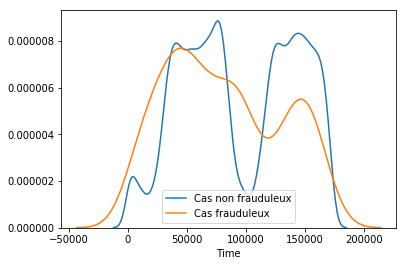

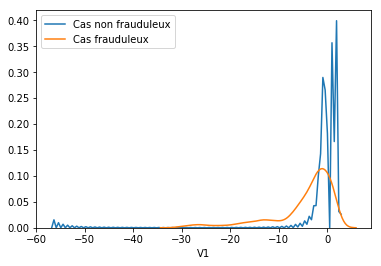

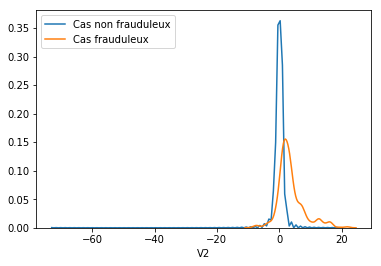

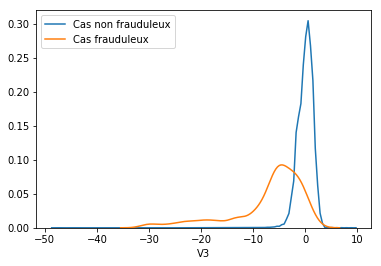

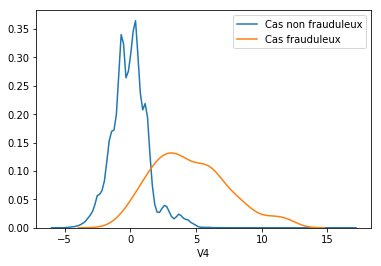

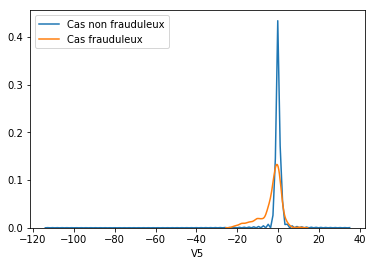

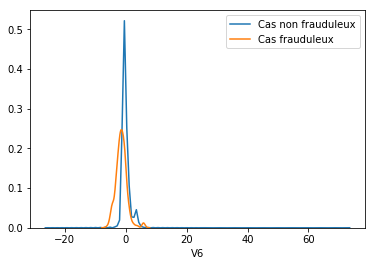

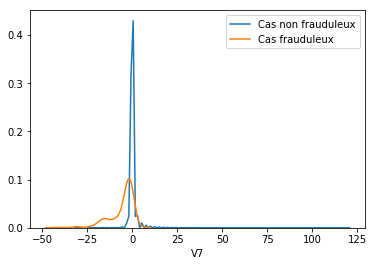

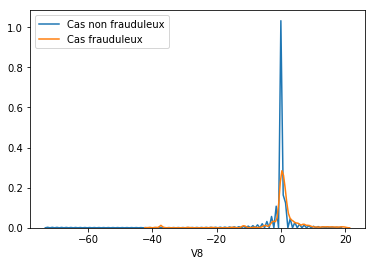

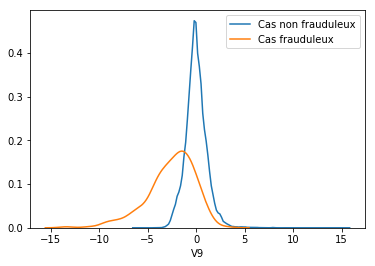

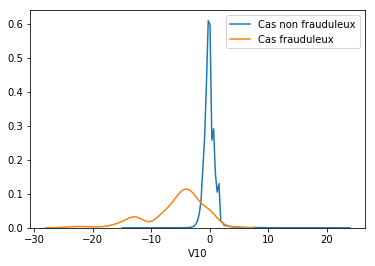

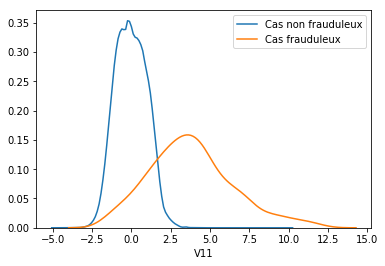

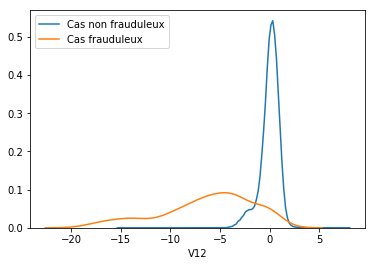

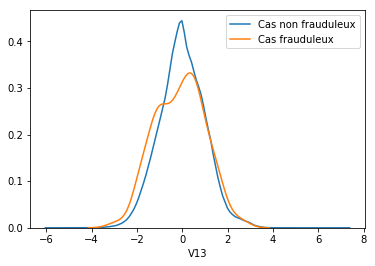

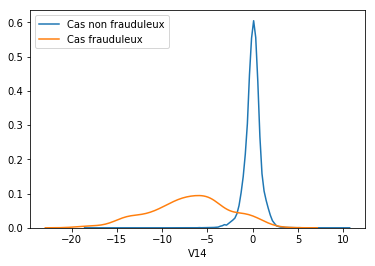

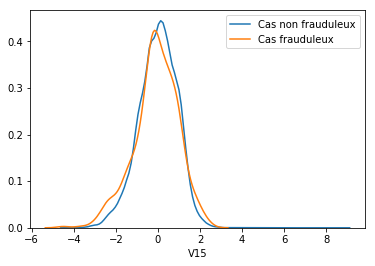

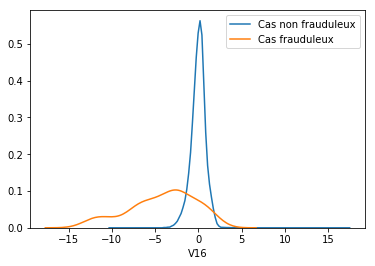

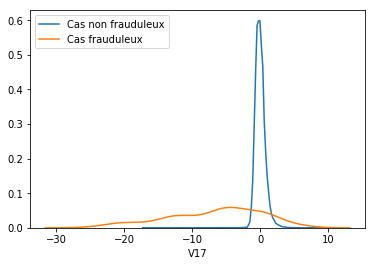

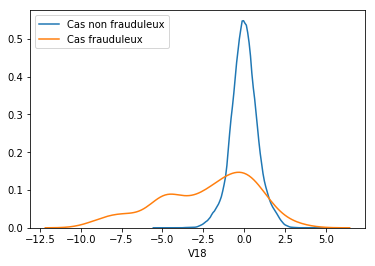

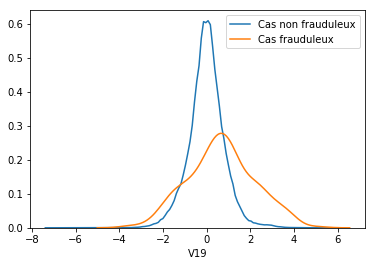

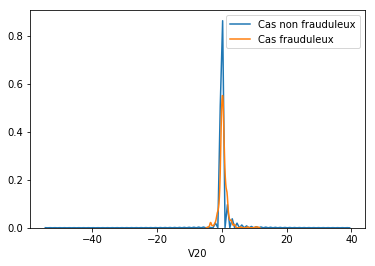

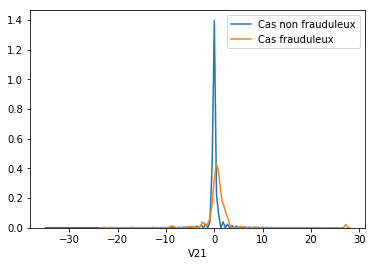

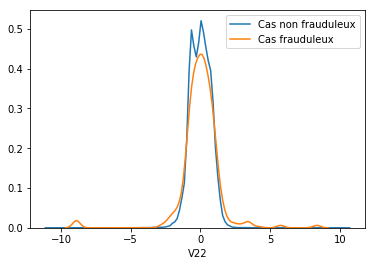

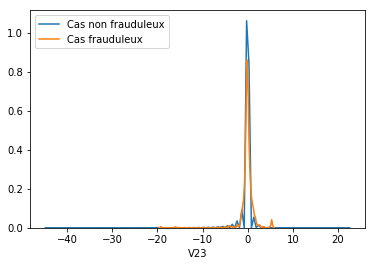

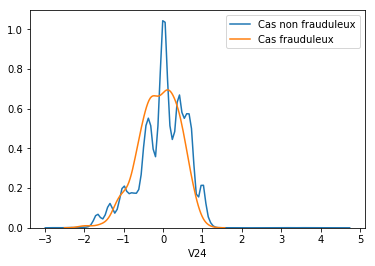

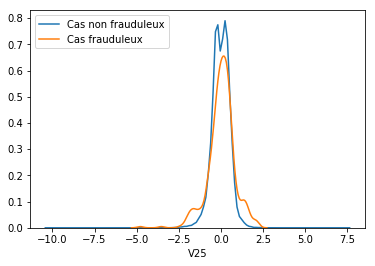

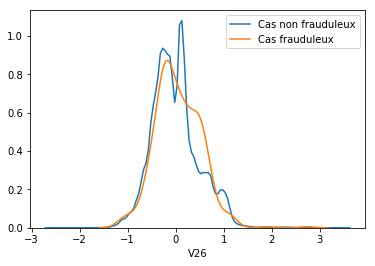

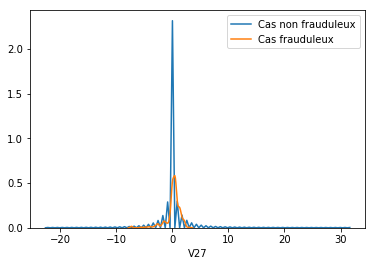

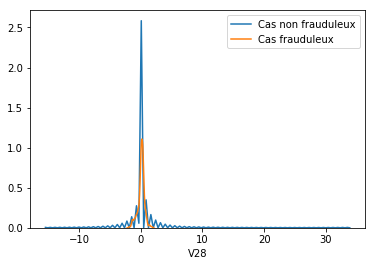

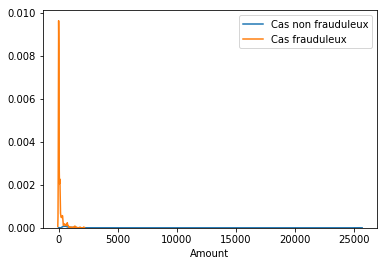

In [197]:
for i, col in enumerate(datasetFraud.columns):
    if col != 'Class':
        plt.figure(i)
        sns.distplot(cas_non_frauduleux[col], hist=False, label='Cas non frauduleux')
        sns.distplot(cas_frauduleux[col],hist=False, label='Cas frauduleux')

* Nous remarquons que certaines distributions se chevauchent presque parfaitement tandis que d'autres sont bien séparées.
* Les distributions qui ne se chevauchent pas reflètent un potentiel de prédiction de la variable en question.
    - Parmis ces variables, on identifie en particulier : __V3, V4, V9, V10, V11, V12, V14, V16, V17__

#### Analyse des corrélation entre variables via la matrice de corrélation

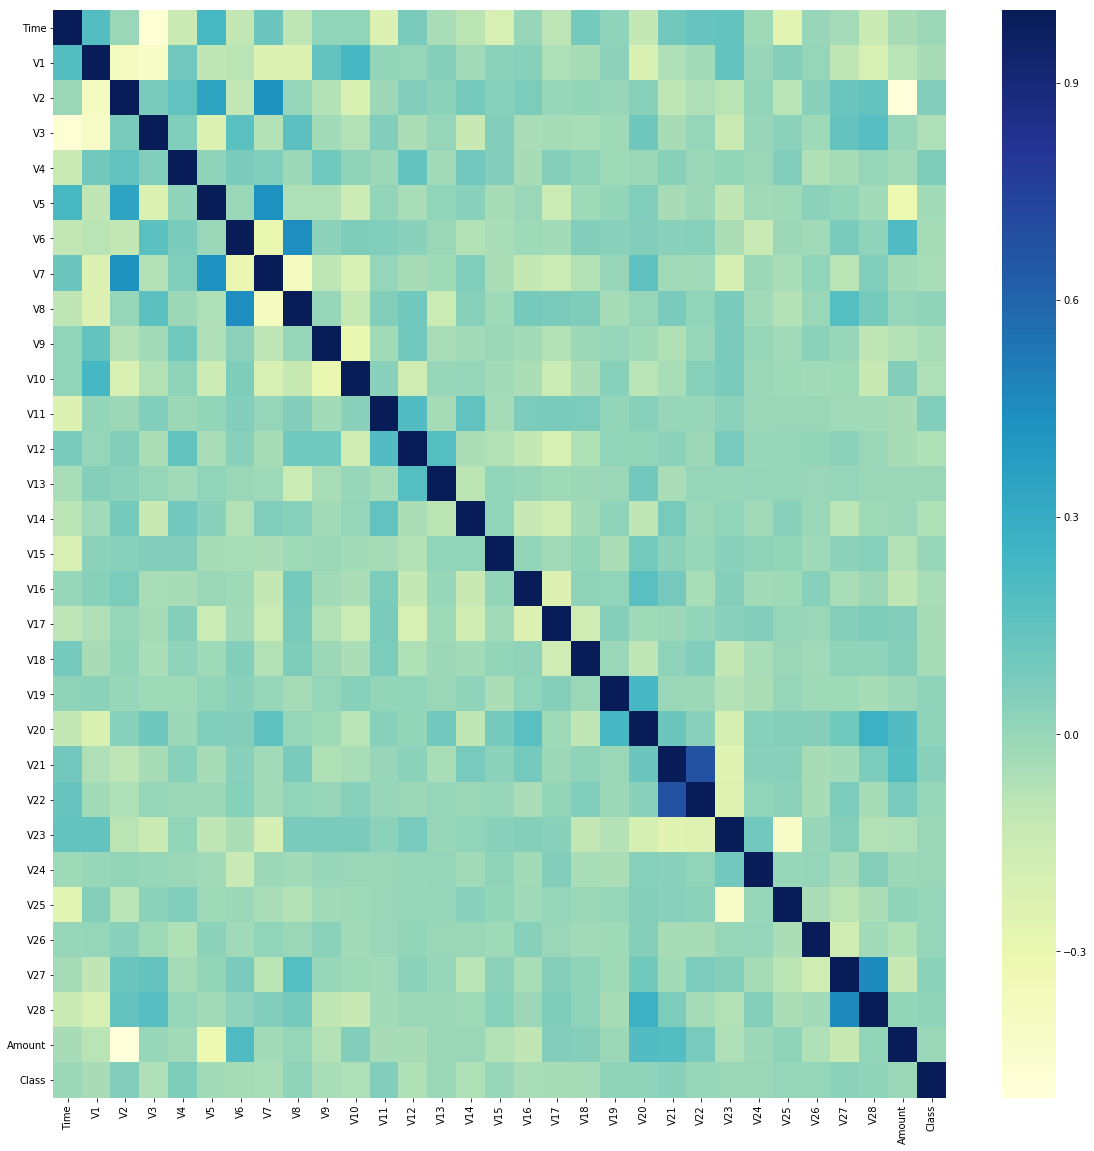

In [40]:
f = plt.subplots(figsize=(20,20))
heatmap = sns.heatmap(datasetFraud.corr(method = "spearman"), cmap= "YlGnBu", annot=False)

* L'analyse de la matrice de corrélation nous permet en général d'identifier les features fortement corrélées entre elles. Elle nous permet également d'identifier d'eventuelles corrélations avec la variable cible.
* Malheureusement cette matrice ne semble pas dégager d'informations pertinentes.
* Très peu de variables semblent nettement corrélées entre elles, à part V22 et V21
* Aucune n'est corrélée avec la variable cible

#### Analysons d'un peu plus près la variable Amount ...

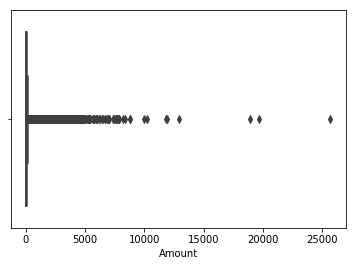

In [339]:
ax = sns.boxplot(x=datasetFraud["Amount"])

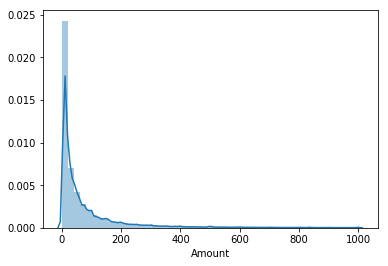

In [29]:
sns.distplot(cas_non_frauduleux.Amount)

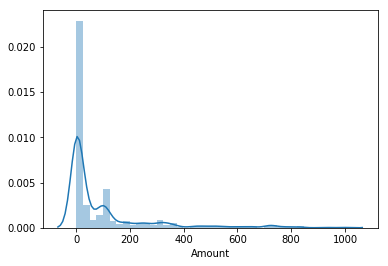

In [30]:
sns.distplot(cas_frauduleux.Amount)

In [340]:
seuil = 1000
cond = datasetFraud.loc[:,'Amount'] > seuil
print('Il y a {} transactions frauduleuses dont le montant dépasse {} euros parmi {} transactions.'
      .format(datasetFraud.loc[cond,'Class'].sum(), seuil, datasetFraud.loc[cond,'Class'].count()))

Il y a 9 transactions frauduleuses dont le montant dépasse 1000 euros parmi 2940 transactions.


* La majorité des transactions semblent concerner des montants inférieurs à 500 euros.
* Nous supprimerons ces outliers. Je choisis toutefois un seuil un peu plus élevé (1000 euros) pour éviter de supprimer trop de cas frauduleux étant donné que nous en avons déjà très peu..

**Attention** : Le modèle risque d'avoir du mal à généraliser au cas où une transaction aurait un montant supérieur à ce seuil.
A voir avec un expert métier pour déterminer si ce seuil semble cohérent ou non.

In [341]:
datasetFraud_copy = datasetFraud.copy()
dataToDrop = datasetFraud.loc[cond,:]
datasetFraud_copy = datasetFraud_copy.drop(dataToDrop.index, axis=0)
datasetFraud_copy.shape

(281867, 31)

* Regardons si nous y voyons plus clair concernant la distribution de notre variable Amount.

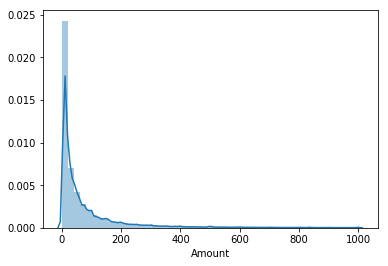

In [33]:
cas_frauduleux = datasetFraud_copy.query('Class == 1')
cas_non_frauduleux = datasetFraud_copy.query('Class == 0')
sns.distplot(cas_non_frauduleux.Amount)

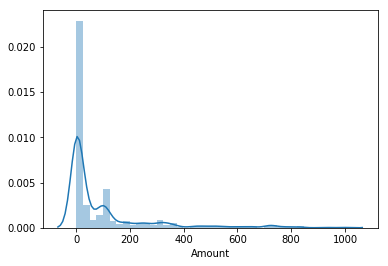

In [34]:
sns.distplot(cas_frauduleux.Amount)

* On observe des paliers fraude / jalons de prix
* On créera donc une variable catégorielle représentant ces différents paliers

In [342]:
datasetFraud_copy["Amount_category"] = datasetFraud_copy["Amount"].apply(lambda x: "400-" if x>=400
                                                                         else "150-400" if x>=150
                                                                         else "50-150" if x>=50
                                                                         else "0-50") 
datasetFraud_copy.loc[:,['Amount_category','Amount']]

,Amount_category,Amount
0,50-150,149.62
1,0-50,2.69
2,150-400,378.66
3,50-150,123.50
4,50-150,69.99
5,0-50,3.67
6,0-50,4.99
7,0-50,40.80
8,50-150,93.20
9,0-50,3.68


# Conclusion de l'analyse exploratoire et stratégie à appliquer ##

- Aucune valeurs manquantes
- Il existe un déséquilibre flagrant entre le nombre de cas non frauduleux et frauduleux : 0.17 % de cas frauduleux
- Concernant la variable Amount, la distribution semble être sensiblement la même pour les cas frauduleux et non frauduleux mais dans le cas de transactions frauduleuses nous distinguons des paliers de prix pour lesquels les fraudes sont plus importantes.
- Certaines variables en particuliers semblent avoir un pouvoir de prédiction plus important (telles que :  V3, V4, V9, V10, V11, V12, V14, V16, V17)

Les prochaines étapes :
- Rééquilibrer les classes 
- Nous pourrons commencer avec un jeu de données ne prenant en compte que les variables identifiées comme "importantes" lors de la data visualisation :  V3, V4, V9, V10, V11, V12, V14, V16, V17, Amount. 
- Utiliser un modèle de classification. Nous testerons en particulier le random Forest, XGBoost
- Evaluer nos modèles en analysant la matrice de confusion et en calculant le Recall et la précision

# Réequilibrage des classes : Oversampling via la méthode SMOTE

##### NB : N'étant pas parvenue à installer le package imblearn pour l'utiliser dans le notebook de Dataiku, j'ai exécuté les lignes de code en local et sauvegardé le train set oversampled au format csv : 'creditcard_resampled.csv'. Même chose pour le test set.
<code>
dataset = pd.read_csv('creditcard.csv')
y = dataset.iloc[:,-1:]
X = dataset.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = .2,
                                                  random_state=12)

smt = SMOTE()
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

df_resample = pd.DataFrame(X_train_res, columns=X.columns)
df_resample['Class'] = y_train_res

df_testSet = X_test.copy()
df_testSet['Class'] = y_test

df_resample.to_csv('creditcard_resampled.csv', index=False))
df_testSet.to_csv('creditcard_testSet.csv', index=False))
</code>

# Training and testing pipeline

In [343]:
dataset_resampled = dataiku.Dataset("creditcard_resampled")
TrainSet = dataset_resampled.get_dataframe()
dataset_test = dataiku.Dataset("creditcard_testSet")
TestSet = dataset_test.get_dataframe()

In [293]:
print(TrainSet.shape)
print(TestSet.shape)

(454892, 31)
(56962, 31)


In [344]:
TrainSet["Amount_category"] = TrainSet["Amount"].apply(lambda x: "400-" if x>=400
                                                                         else "150-400" if x>=150
                                                                         else "50-150" if x>=50
                                                                         else "0-50") 

TestSet["Amount_category"] = TestSet["Amount"].apply(lambda x: "400-" if x>=400
                                                                         else "150-400" if x>=150
                                                                         else "50-150" if x>=50
                                                                         else "0-50") 


In [345]:
X_train = TrainSet.loc[:,['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Amount_category']]
X_test = TestSet.loc[:,['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Amount_category']]
y_train = TrainSet.loc[:,'Class']
y_test = TestSet.loc[:,'Class']

In [329]:
print(X_train.head())
print(X_train.shape)
print()
print(X_test.head())
print(X_test.shape)

         V3        V4        V9       V10       V11       V12       V14       V16       V17 Amount_category
0 -0.008264 -1.551405 -0.745229  1.636882  0.245280 -0.268694 -0.675722  0.204526 -0.020036          50-150
1 -2.218584 -0.572909 -0.378501  0.688815  0.007357  0.095716  0.657760 -2.069385  0.038462         150-400
2  1.192146  3.021850 -0.936928  0.657810 -2.001062 -0.458508 -0.401790  0.312348 -0.481132          50-150
3  0.490862  2.811443 -2.181001  0.084548 -0.618644 -0.185590  1.117689 -0.075040  0.374312          50-150
4 -1.132609  0.384436  0.604173  0.084106 -0.932125  0.205757  0.335267 -0.046054 -0.321943            0-50
(451066, 10)
()
         V3        V4        V9        V10       V11        V12        V14       V16        V17 Amount_category
0 -0.150277 -1.747054 -0.925699   1.648925  0.373273   0.015713  -0.794090  0.332583  -0.205805            0-50
1 -9.523349  5.791918 -3.297625 -10.957551  9.540746 -14.745849 -13.127971 -9.860339 -16.511143          50-150


### Training Pipeline

##### Normalisation des variables X quantitatives et encodage des variables X catégorielles

In [346]:
print("--- Training pipeline ---\nEncodage de la variable Amount...\n")
print("Avant la transformation :")
print(X_train.head())

categorical_transformer = OneHotEncoder(categories='auto')

cat = categorical_transformer.fit_transform(X_train.Amount_category.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(cat, columns = ["Amount_"+str(int(i)) for i in range(cat.shape[1])])
X_train = pd.concat([X_train.iloc[:,:-1], dfOneHot], axis=1)

print("...Done\n")
print("Après la transformation :")
print(X_train.head())

--- Training pipeline ---
Encodage de la variable Amount...

Avant la transformation :
         V3        V4        V9       V10       V11       V12       V14       V16       V17 Amount_category
0 -0.008264 -1.551405 -0.745229  1.636882  0.245280 -0.268694 -0.675722  0.204526 -0.020036          50-150
1 -2.218584 -0.572909 -0.378501  0.688815  0.007357  0.095716  0.657760 -2.069385  0.038462         150-400
2  1.192146  3.021850 -0.936928  0.657810 -2.001062 -0.458508 -0.401790  0.312348 -0.481132          50-150
3  0.490862  2.811443 -2.181001  0.084548 -0.618644 -0.185590  1.117689 -0.075040  0.374312          50-150
4 -1.132609  0.384436  0.604173  0.084106 -0.932125  0.205757  0.335267 -0.046054 -0.321943            0-50
...Done

Après la transformation :
         V3        V4        V9       V10       V11       V12       V14       V16       V17  Amount_0  Amount_1  Amount_2  Amount_3
0 -0.008264 -1.551405 -0.745229  1.636882  0.245280 -0.268694 -0.675722  0.204526 -0.020036       

##### Entrainement de modèles

In [347]:
# Modèle RandomForest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=12)
clf_rf.fit(X_train, y_train)

# XGboost
classifier_xgb = XGBClassifier(random_state=12, n_estimators=100)
classifier_xgb.fit(X_train, y_train)

# Extra Tree
et =  ExtraTreesClassifier(n_estimators=100, max_depth=6)
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=6, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Testing Pipeline

##### Normalisation des variables X quantitatives et encodage des variables X catégorielles

In [348]:
print("--- Testing pipeline ---\nEncodage de la variable Amount...\n")
print("Avant la transformation :")
print(X_test.head())

cat_test = categorical_transformer.transform(X_test.Amount_category.values.reshape(-1,1)).toarray()
dfOneHot_test = pd.DataFrame(cat_test, columns = ["Amount_"+str(int(i)) for i in range(cat_test.shape[1])])
X_test = pd.concat([X_test.iloc[:,:-1], dfOneHot_test], axis=1)

print("...Done\n")
print("Après la transformation :")
print(X_test.head())

--- Testing pipeline ---
Encodage de la variable Amount...

Avant la transformation :
         V3        V4        V9        V10       V11        V12        V14       V16        V17 Amount_category
0 -0.150277 -1.747054 -0.925699   1.648925  0.373273   0.015713  -0.794090  0.332583  -0.205805            0-50
1 -9.523349  5.791918 -3.297625 -10.957551  9.540746 -14.745849 -13.127971 -9.860339 -16.511143          50-150
2  1.806368  0.001411 -0.307311  -0.582247  0.512150  -0.161977   0.252321  0.670752  -0.977498          50-150
3 -0.380629  1.110728  0.782612   0.417699  0.228437   0.418075   0.303735  0.825682  -1.174419            0-50
4  0.780046 -2.595803  0.384674  -0.717940  0.626973   0.749119  -0.233775  0.267418  -0.639912            0-50
...Done

Après la transformation :
         V3        V4        V9        V10       V11        V12        V14       V16        V17  Amount_0  Amount_1  Amount_2  Amount_3
0 -0.150277 -1.747054 -0.925699   1.648925  0.373273   0.015713  -0.794

### Prédictions

In [349]:
y_train_pred_rf = clf_rf.predict(X_train)
y_test_pred_rf = clf_rf.predict(X_test)

y_train_pred_xg = classifier_xgb.predict(X_train)
y_test_pred_xg = classifier_xgb.predict(X_test)

y_train_pred_et = et.predict(X_train)
y_test_pred_et = et.predict(X_test)

### Evaluation des performances

In [350]:
# Random Forest
print('RANDOM FOREST - Train Results : ')
print('-- Recall : {:.2f}'.format(recall_score(y_train, y_train_pred_rf)))
print('-- Precision : {:.2f}'.format(precision_score(y_train, y_train_pred_rf)))
print('RANDOM FOREST - Test Results :')
print('-- Recall : {:.2f}'.format(recall_score(y_test, y_test_pred_rf)))
print('-- Precision : {:.2f}'.format(precision_score(y_test, y_test_pred_rf)))

# XGboost
print('\nXGBOOST - Train Results : ')
print('-- Recall : {:.2f}'.format(recall_score(y_train, y_train_pred_xg)))
print('-- Precision : {:.2f}'.format(precision_score(y_train, y_train_pred_xg)))
print('XGBOOST- Test Results')
print('-- Recall : {:.2f}'.format(recall_score(y_test, y_test_pred_xg)))
print('-- Precision : {:.2f}'.format(precision_score(y_test, y_test_pred_xg)))

# Extra Trees
print('\nEXTRA TREES - Train Results : ')
print('-- Recall : {:.2f}'.format(recall_score(y_train, y_train_pred_et)))
print('-- Precision : {:.2f}'.format(precision_score(y_train, y_train_pred_et)))
print('EXTRA TREES - Test Results')
print('-- Recall : {:.2f}'.format(recall_score(y_test, y_test_pred_et)))
print('-- Precision : {:.2f}'.format(precision_score(y_test, y_test_pred_et)))


RANDOM FOREST - Train Results : 
-- Recall : 1.00
-- Precision : 1.00
RANDOM FOREST - Test Results :
-- Recall : 0.84
-- Precision : 0.86

XGBOOST - Train Results : 
-- Recall : 0.97
-- Precision : 0.99
XGBOOST- Test Results
-- Recall : 0.89
-- Precision : 0.14

EXTRA TREES - Train Results : 
-- Recall : 0.88
-- Precision : 1.00
EXTRA TREES - Test Results
-- Recall : 0.83
-- Precision : 0.57


Text(0.5,1,'Extra trees')

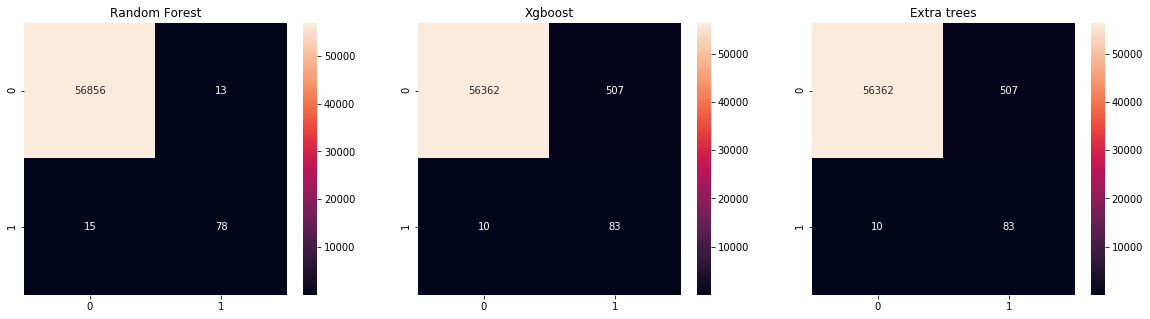

In [149]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_boost = confusion_matrix(y_test, y_test_pred_xg)
cm_et = confusion_matrix(y_test, y_test_pred_et)

fig = plt.figure(figsize = (20,5)) # width x height
ax1 = fig.add_subplot(1, 3, 1) # row, column, position
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

sns.heatmap(cm_rf, annot=True, fmt="d", ax=ax1)
ax1.set_title('Random Forest')
sns.heatmap(cm_boost, annot=True, fmt="d", ax=ax2)
ax2.set_title('Xgboost')
sns.heatmap(cm_boost, annot=True, fmt="d", ax=ax3)
ax3.set_title('Extra trees')

##### Analyse des résultats :
* Le random forest nous donne de bons résultats ! On remarque toutefois un peu d'overfitting. 
* Essayons d'améliorer cela en jouant sur les features et les hyperparamètres du modèle.

In [141]:
clf_rf.feature_importances_

array([0.04805913, 0.12552056, 0.02694462, 0.1812259 , 0.06029992,
       0.11739804, 0.28745204, 0.02068285, 0.12551147, 0.00220107,
       0.0008874 , 0.00280914, 0.00100787])

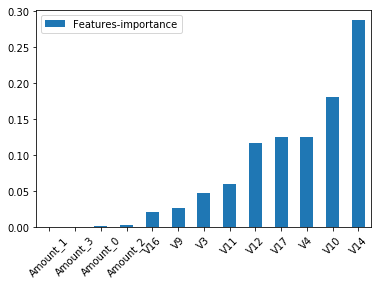

In [164]:
features = {} # un dictionnaire pour associer les noms des variables au dégré d'importance de celles-ci
for feature, importance in zip(X_train.columns, clf_rf.feature_importances_):
    features[feature] = importance 

importances = pd.DataFrame.from_dict(features, orient='index').rename(columns={0: 'Features-importance'})
importances.sort_values(by='Features-importance').plot(kind='bar', rot=45)

In [232]:
# Après quelques essais en retirant les variables moins importantes cela a pour effet de diminuer le score de précision.
# La diminution est plus légère concernant la variable catégorielle Amount_category

In [208]:
clf_rf1 = RandomForestClassifier(random_state=12)
params = {
    'n_estimators' : [100, 120]
    'max_depth' : [20, 25, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1.0, 2, 5]
}
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(clf_rf1, params, random_state=12, n_iter=100, cv=5, verbose=0, n_jobs=-1)

In [209]:
# Fit randomized search
best_model = clf.fit(X_train, y_train)

/data/saas-instances/saas_cfnrrjxh/install/python.packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [218]:
best_model.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}

In [259]:
clf_rf2 = RandomForestClassifier(n_estimators = 50, 
                                 random_state=12, 
                                 max_depth =20, 
                                 min_samples_leaf = 2, 
                                 min_samples_split = 5 )

In [260]:
clf_rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [261]:
#Prédictions
y_train_pred_RandSearch = clf_rf2.predict(X_train)
y_test_pred_RandSearch = clf_rf2.predict(X_test)
# Random Forest - scores
print('RANDOM FOREST - Train Results : ')
print('-- Recall : {:.2f}'.format(recall_score(y_train, y_train_pred_RandSearch)))
print('-- Precision : {:.2f}'.format(precision_score(y_train, y_train_pred_RandSearch)))
print('RANDOM FOREST - Test Results :')
print('-- Recall : {:.2f}'.format(recall_score(y_test, y_test_pred_RandSearch)))
print('-- Precision : {:.2f}'.format(precision_score(y_test, y_test_pred_RandSearch)))

RANDOM FOREST - Train Results : 
-- Recall : 1.00
-- Precision : 1.00
RANDOM FOREST - Test Results :
-- Recall : 0.83
-- Precision : 0.81


# CONCLUSION

* Les variables qui semblent avoir le plus d'influences sur la prédiction de transactions frauduleuses sont les suivantes :
    - V3, V4, V9, V10, V11, V12, V14, V16, V17, Amount
    
* Il serait intéressant d'avoir accès aux variables d'origines afin de pouvoir émettre des recommandations ou de faire du feature engineering.

* Notre modèle présente un score de précision et de recall honorable. La prochaine étape serait de parvenir à diminuer l'overfitting. Avec un grid_search autour des paramètres trouvés par le randomzided_search (__cf modèle généré via la plateforme Dataiku__)

* Cet overfitting est peut être dû à notre choix de supprimer les transactions supérieures à 1000 euros.

* POur augmenter le score : 
    - tester d'autres modèles et méthodes (stacking, MLP..)
    - Obtenir plus de données correspondant à des transaction frauduleuses
    - Avoir plus d'informations concernant les variables Vx issues d'une PCA